## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'coco-outdoor' 
TRANSFORM = 'wavelet-horizontal'
CHANNEL = 'blue'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
blue_horizontal_wavelet_outdoor_coco.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/coco/outdoor/wavelet/horizontal/blue'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 2446,
 3: 9784,
 4: 39136,
 5: 156544,
 6: 626176,
 7: 2504704,
 8: 10018816,
 9: 40075264}

Running 12760 CDFs


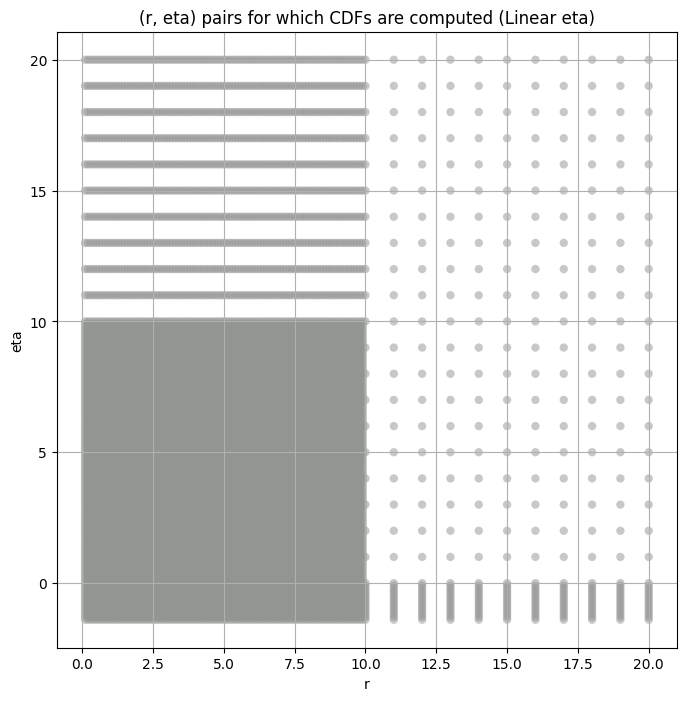

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df['total_samples'] = master_df['total_samples'].astype(int)
    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 4


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 7


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 9


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      8164.916000  7605.077600  8740.630000  -0.209310   -0.378561   
3      1626.509200  1553.716800  1701.747200   1.064677    0.871749   
4       312.339840   295.463650   329.815400   2.542057    2.153969   
5        59.957355    55.956010    64.163605   5.134632    4.186793   
6        11.683060    10.743300    12.710672   8.652102    6.385494   
7         2.319137     2.099334     2.582869  13.925329    8.620293   
8         0.518750     0.462717     0.602915  23.163664   10.309817   
9         0.140365     0.124805     0.164263  25.354736   11.124588   

       kurt_upper  total_samples  
layer                             
2       -0.024999           2446  
3        1.268122           9784  
4        2.983537          39136  
5        6.364203         156544  
6       15.483664         626176  
7       37.670284        2504704  
8       97.696720       10018816  
9      102.650770       40075264

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                               
2      8164.916000    8164.916016     7243.903320     6627.400391   
3      1626.509200    1626.509155     1530.214355     1459.587646   
4       312.339840     312.339844      303.580750      297.142456   
5        59.957355      59.957355       58.635273       57.738342   
6        11.683060      11.683060       11.306233       11.078835   
7         2.319137       2.319137        2.219886        2.165088   
8         0.518750       0.518750        0.491109        0.477461   
9         0.140365       0.140365        0.132448        0.128547   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2         6089.405273      5620.104980      4849.695801      4210.077148   
3         1401.546997      1350.162598      1258.268433      1179.584595   
4          291.530762       286.471954       277.375671       269.202332   
5           56.955723        56.252537        54.998043        53.881351   
6           10.885950        10.714915        10.412787        10.145769   
7            2.119277         2.078659         2.007725         1.945922   
8            0.465992         0.455843         0.438175         0.422887   
9            0.125305         0.122454         0.117509         0.113247   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2          3652.953125      3166.041748      2742.948730      1696.276611  
3          1110.251587      1047.717773       990.727417       844.227356  
4           261.756348       254.886810       248.475784       231.317917  
5            52.866451        51.929096        51.050064        48.673744  
6             9.904416         9.683002         9.477492         8.931730  
7             1.890694         1.840316         1.793858         1.672048  
8             0.409294         0.397007         0.385760         0.356689  
9             0.109462         0.106046         0.102923         0.094874

####
Layer  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.08455787906836609 8164.916


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.08955589877296499 7243.9033


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.10007884806245071 6627.4004


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.10999686836759781 6089.4053


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.11921858940997632 5620.105


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.13559076174333484 4849.696


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.15116229333818976 4210.077


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.16700630316447918 3652.9531


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.1829471207572002 3166.0417


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.1988751965087272 2742.9487


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.2510596143446362 1696.2766
Number of samples: 2446, Without approximation : 2446


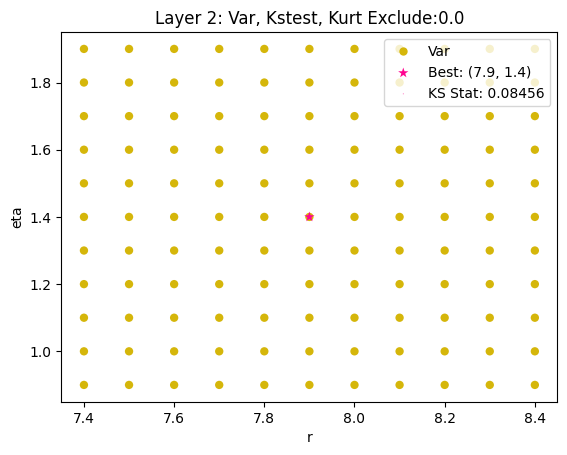

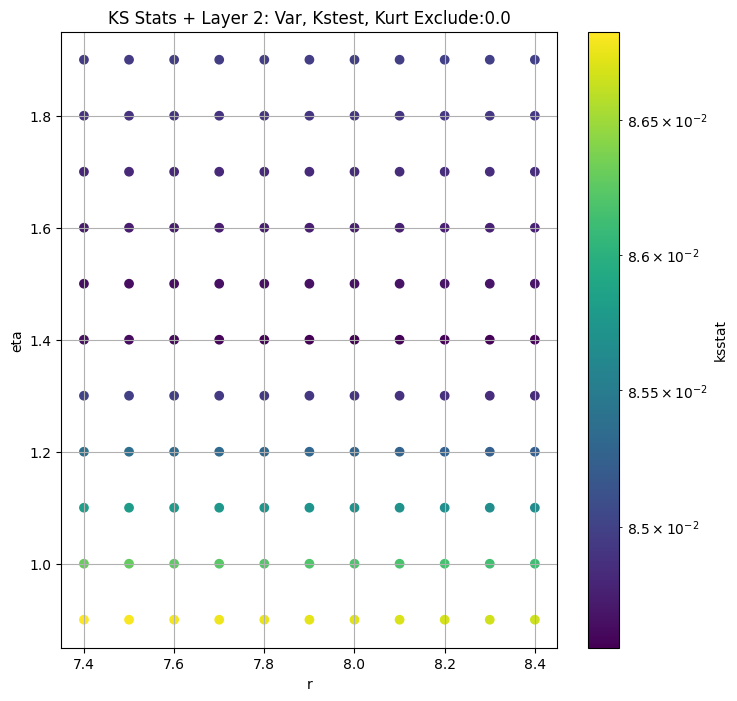

####
Layer  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.06841504865129322 1626.5092


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 0.06841496442717365 1530.2144


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 0.06841531755626618 1459.5876


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 0.06841637954443869 1401.547


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 0.06841833611356296 1350.1626


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 0.06841991439724593 1258.2684


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 0.0684172364382839 1179.5846


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 0.0684169078872966 1110.2516


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 0.06972657937048138 1047.7178


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 0.07305586062340796 990.7274


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 0.08822502982183011 844.22736
Number of samples: 9784, Without approximation : 9784


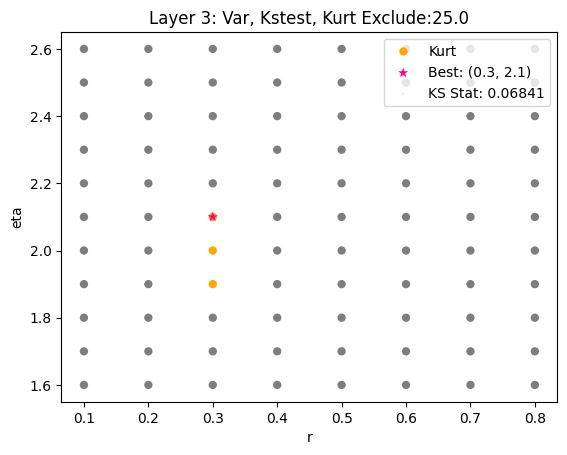

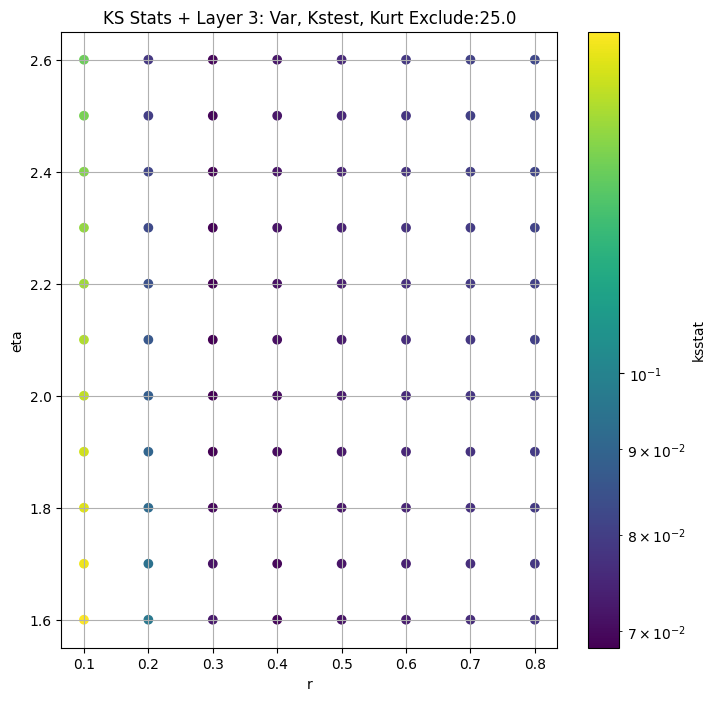

####
Layer  4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 0 0.04686656492016095 312.33984


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 25 0.04687455178616129 303.58075


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 50 0.046880201016921696 297.14246


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 75 0.046881240222563236 291.53076


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 100 0.04686092179322726 286.47195


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 150 0.04686039103001172 277.37567


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 200 0.04686405237240965 269.20233


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 250 0.04686921176048914 261.75635


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 300 0.04687351383205285 254.88681


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 350 0.04687279471611 248.47578


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 500 0.046867206528381056 231.31792
Number of samples: 39136, Without approximation : 39136


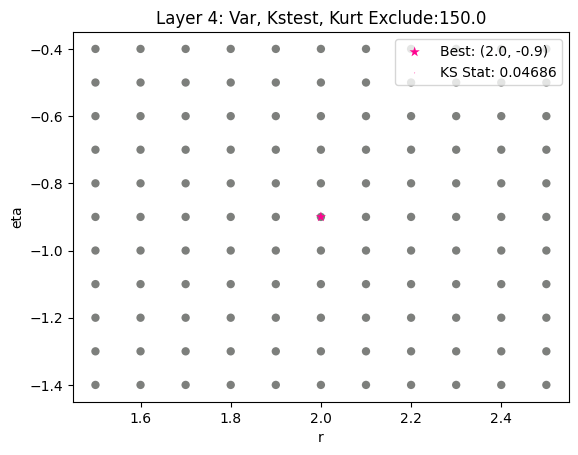

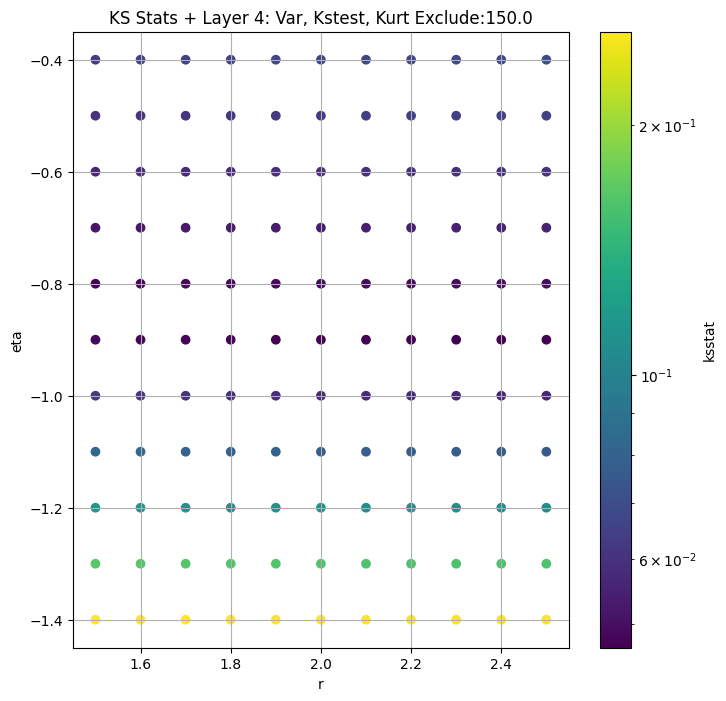

####
Layer  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.036994084274711125 59.957355


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.037191293765141686 58.635273


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.0368052360902244 57.738342


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.03691639196680879 56.955723


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.03701809630551761 56.252537


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.0367841321904368 54.998043


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.036951391212206086 53.88135


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.03675984540980731 52.86645


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.03690555138588908 51.929096


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.036753737738280334 51.050064


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.03668403658913583 48.673744
Number of samples: 100000, Without approximation : 156544


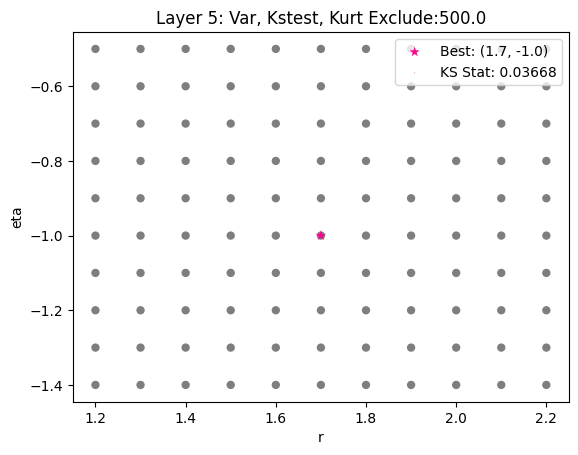

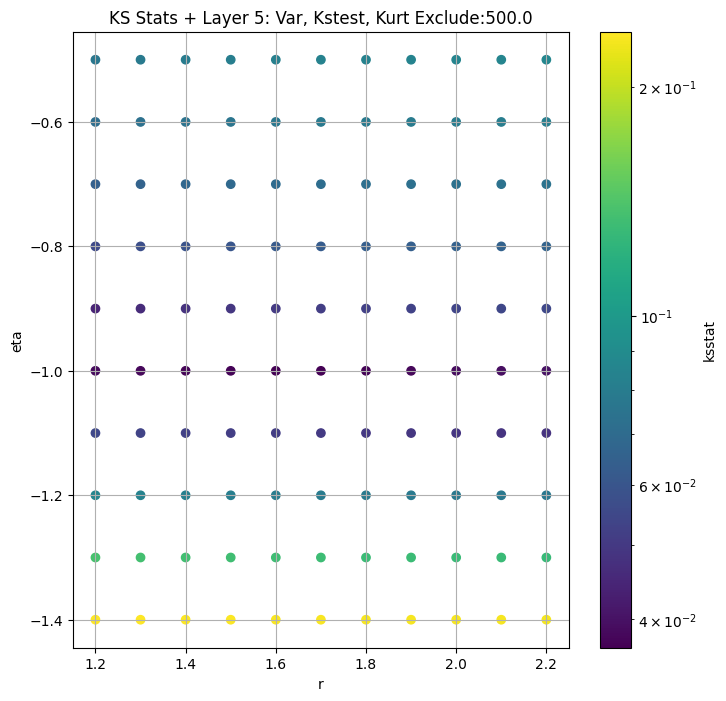

####
Layer  6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 0 0.029815616547825496 11.68306


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 25 0.02969896973988434 11.306233


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 50 0.02962588840442215 11.0788355


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 75 0.029562222532514004 10.88595


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 100 0.029504427610672457 10.714915


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 150 0.02939910405008339 10.412787


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 200 0.02930239557512565 10.145769


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 250 0.029211875473708238 9.904416


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 300 0.029371962775129212 9.6830015


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 350 0.029669126420741376 9.477492


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 500 0.02971530455904653 8.93173
Number of samples: 100000, Without approximation : 626176


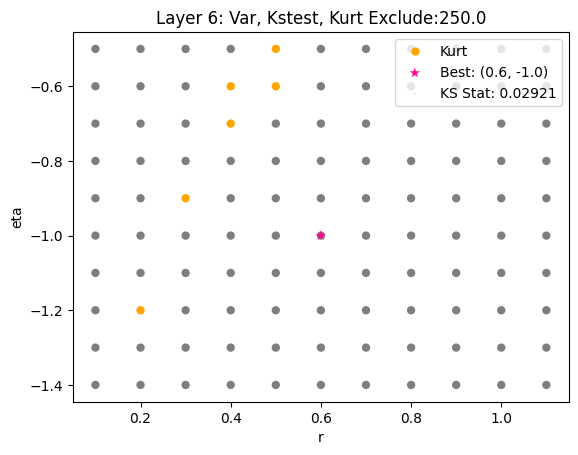

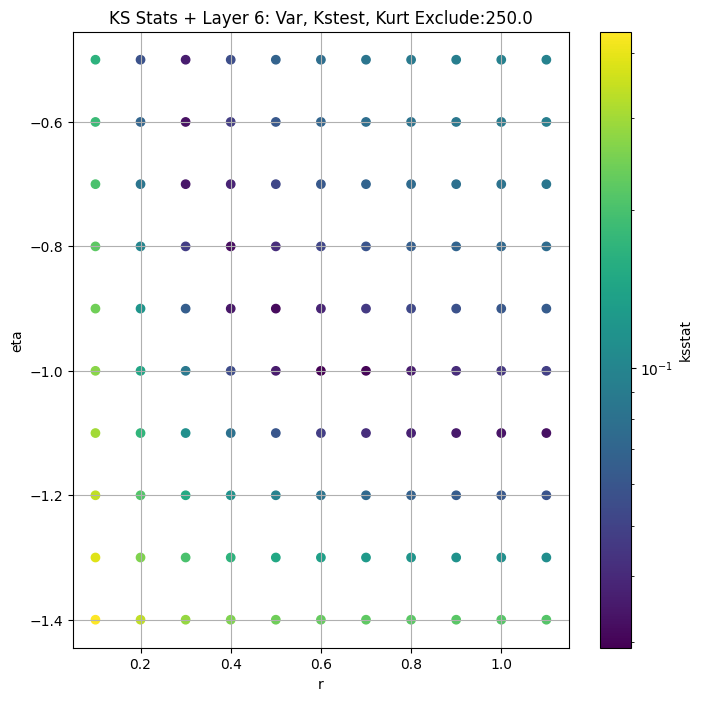

####
Layer  7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 0 0.02712968848426006 2.3191366


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 25 0.02679075423927102 2.2198863


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 50 0.02659481228763788 2.1650882


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 75 0.026425855476643 2.119277


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 100 0.02627192689684188 2.0786593


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 150 0.02599324655763141 2.007725


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 200 0.02615718632629005 1.9459218


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 250 0.026960445093443752 1.8906938


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 300 0.026749873379727562 1.8403157


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 350 0.026548710819803034 1.7938583


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 500 0.025986289917281413 1.6720481
Number of samples: 100000, Without approximation : 2504704


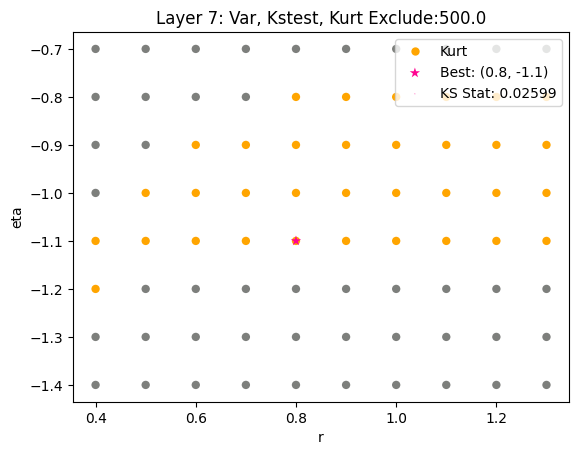

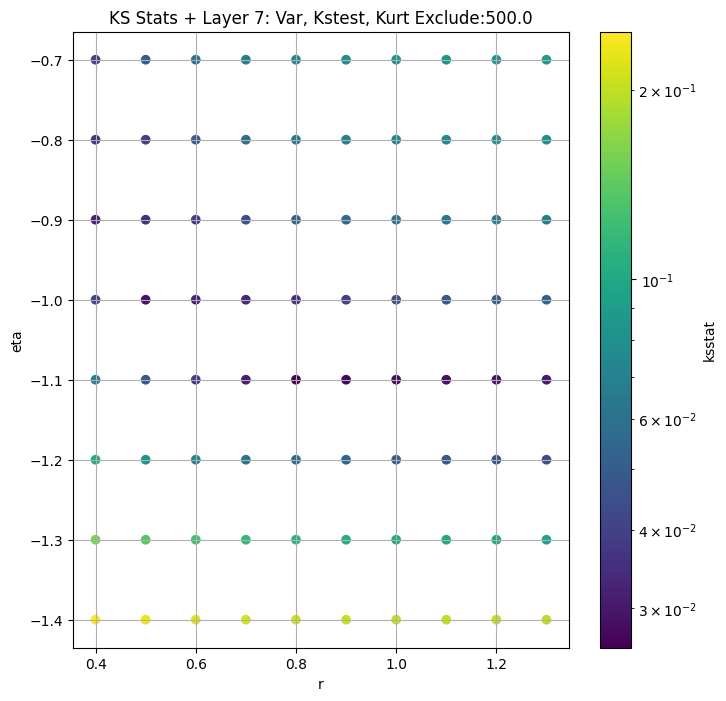

####
Layer  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.013487870020038706 0.5187497


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.015120291172607492 0.49110946


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.014323287720154787 0.47746104


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.014833214371088976 0.46599218


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.015468575737366597 0.45584255


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.016629250213765046 0.43817484


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.01694290159073475 0.42288727


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.015104431053153844 0.40929413


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.014059464429764579 0.39700657


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.014154892716291667 0.38575992


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.014942848665878916 0.35668924
Number of samples: 100000, Without approximation : 10018816


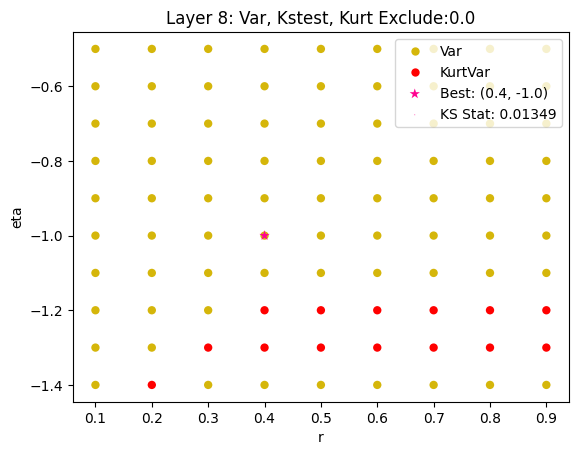

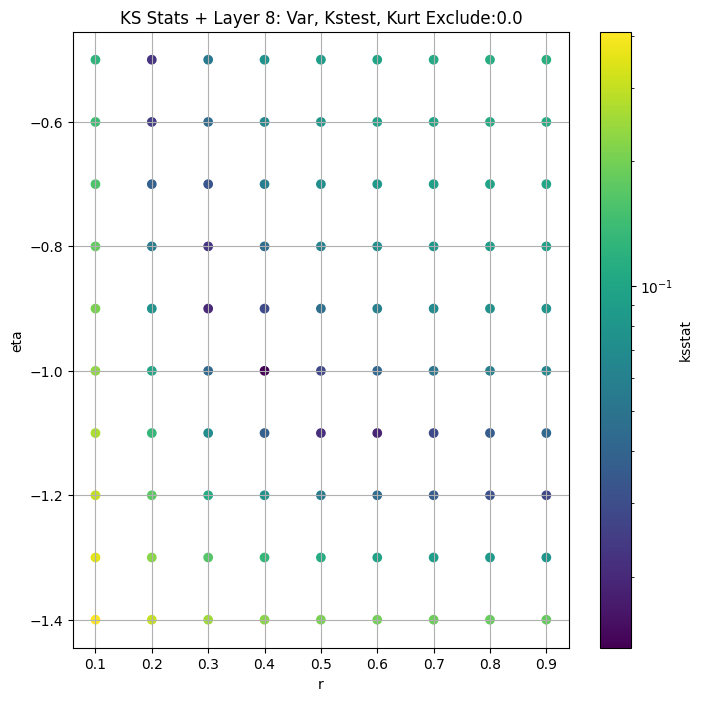

####
Layer  9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 0 0.01404927284389651 0.14036545


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 25 0.012811526204696166 0.13244775


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 50 0.012410718389807673 0.12854655


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 75 0.013237542273033531 0.12530546


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 100 0.013436421044294766 0.122454375


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 150 0.013794827719530445 0.11750917


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 200 0.01254097205684851 0.113246754


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 250 0.01137110035442046 0.10946243


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 300 0.013050726821901115 0.106045626


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 350 0.012981152168518029 0.10292337


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 500 0.012546290439404029 0.09487382
Number of samples: 100000, Without approximation : 40075264


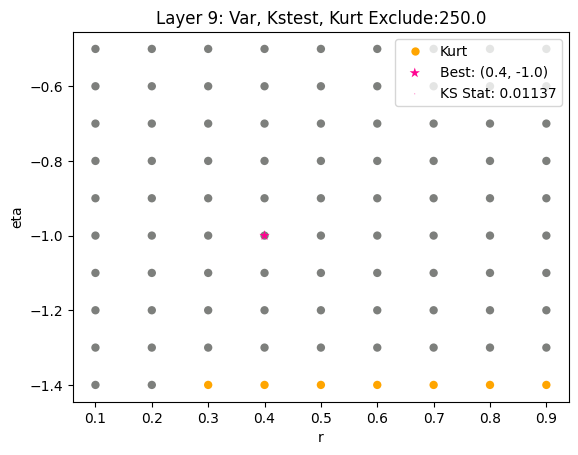

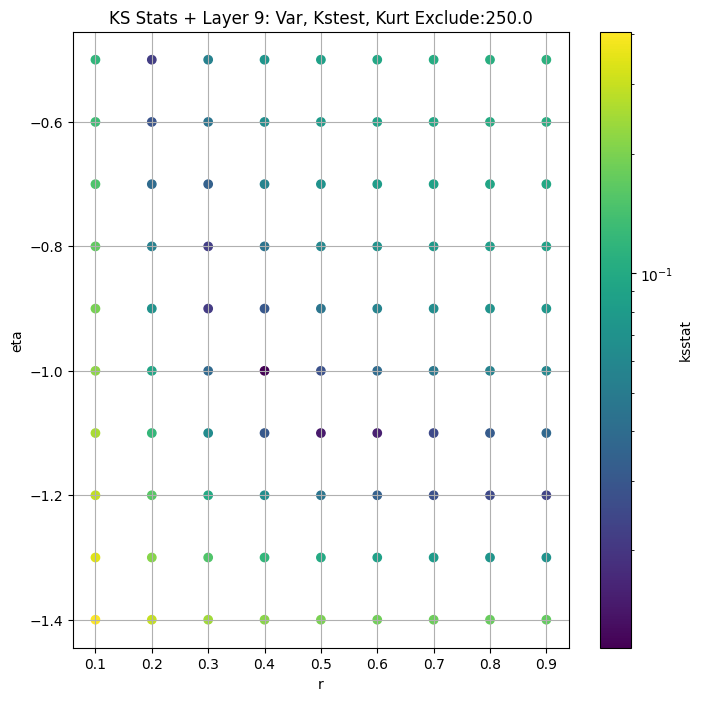

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      8164.916000  7605.077600  8740.630000  -0.209310   -0.378561   
3      1626.509200  1553.716800  1701.747200   1.064677    0.871749   
4       312.339840   295.463650   329.815400   2.542057    2.153969   
5        59.957355    55.956010    64.163605   5.134632    4.186793   
6        11.683060    10.743300    12.710672   8.652102    6.385494   
7         2.319137     2.099334     2.582869  13.925329    8.620293   
8         0.518750     0.462717     0.602915  23.163664   10.309817   
9         0.140365     0.124805     0.164263  25.354736   11.124588   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2       -0.024999           2446             0.084558        7.9          1.4   
3        1.268122           9784             0.068415        0.3          2.1   
4        2.983537          39136             0.046860        2.0         -0.9   
5        6.364203         156544             0.036684        1.7         -1.0   
6       15.483664         626176             0.029212        0.6         -1.0   
7       37.670284        2504704             0.025986        0.8         -1.1   
8       97.696720       10018816             0.013488        0.4         -1.0   
9      102.650770       40075264             0.011371        0.4         -1.0   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       11024.006477                     0.0         8164.916000   
3           0.286218                    25.0         1530.214400   
4         712.736023                   150.0          277.375670   
5         137.243191                   500.0           48.673744   
6           8.410168                   250.0            9.904416   
7           3.224621                   500.0            1.672048   
8           0.106307                     0.0            0.518750   
9           0.022432                   250.0            0.109462   

       kstest_stat_cutoff_0.05  
layer                           
2                     0.027391  
3                     0.013713  
4                     0.006861  
5                     0.003431  
6                     0.001716  
7                     0.000858  
8                     0.000429  
9                     0.000215

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


  0%|          | 0/90 [00:00<?, ?it/s]

Finding Minimum after computing 90 CDFs
layer 2, 0.0 + 100 = 100, ksstat: 0.12172337765536212, var: 5620.10498046875


  0%|          | 0/90 [00:00<?, ?it/s]

Finding Minimum after computing 90 CDFs
layer 2, 0.0 + 75 = 75, ksstat: 0.11289315168400582, var: 6089.4052734375


  0%|          | 0/90 [00:00<?, ?it/s]

Finding Minimum after computing 90 CDFs
layer 2, 0.0 + 50 = 50, ksstat: 0.10337170538011908, var: 6627.400390625


  0%|          | 0/90 [00:00<?, ?it/s]

Finding Minimum after computing 90 CDFs
layer 2, 0.0 + 25 = 25, ksstat: 0.09319130410748866, var: 7243.9033203125


  0%|          | 0/90 [00:00<?, ?it/s]

Finding Minimum after computing 90 CDFs
layer 2, 0.0 + 0 = 0, ksstat: 0.08455787906836609, var: 8164.916015625
Number of samples: 2446, Without approximation : 2446


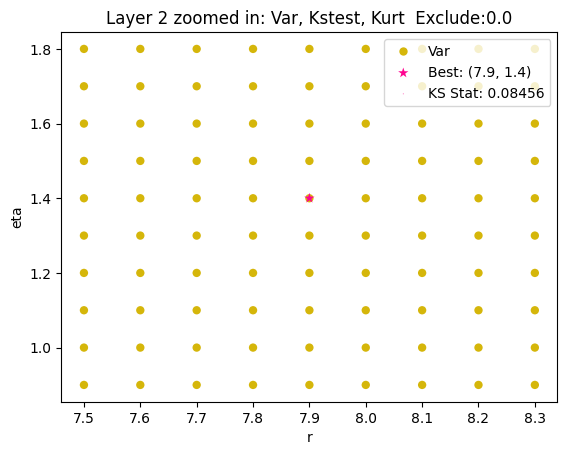

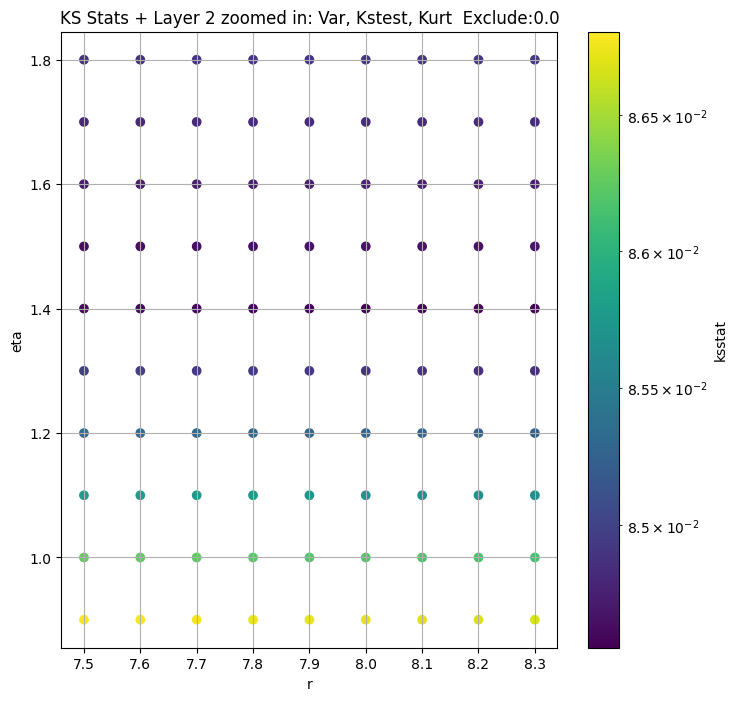

Layer 3


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
layer 3, 25.0 + 100 = 125, ksstat: 0.06846320005523543, var: 1302.3656005859375


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
layer 3, 25.0 + 75 = 100, ksstat: 0.0684139646166737, var: 1350.16259765625


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
layer 3, 25.0 + 50 = 75, ksstat: 0.06841437002923595, var: 1401.5469970703125


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
layer 3, 25.0 + 25 = 50, ksstat: 0.0684196393171953, var: 1459.587646484375


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
layer 3, 25.0 + 0 = 25, ksstat: 0.06841492965092077, var: 1530.21435546875


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
layer 3, 25.0 + -25 = 0, ksstat: 0.0684145182234498, var: 1626.5091552734375
Number of samples: 9784, Without approximation : 9784


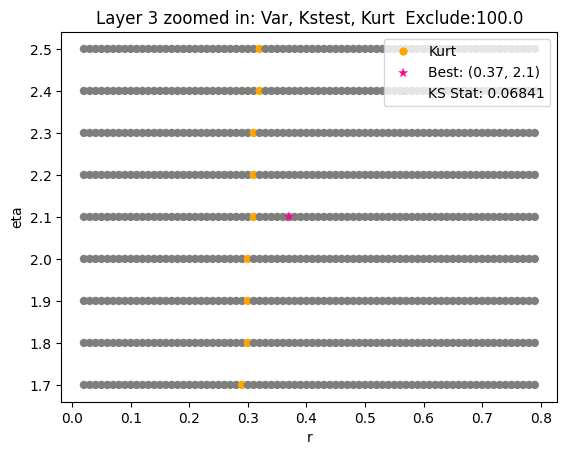

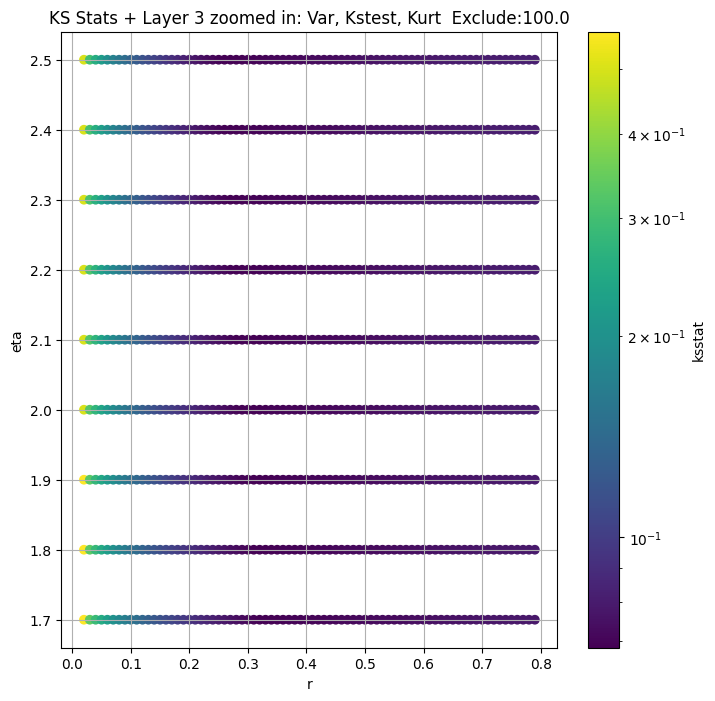

Layer 4


  0%|          | 0/990 [00:00<?, ?it/s]

Finding Minimum after computing 990 CDFs
layer 4, 150.0 + 100 = 250, ksstat: 0.04692987859639447, var: 261.75634765625


  0%|          | 0/990 [00:00<?, ?it/s]

Finding Minimum after computing 990 CDFs
layer 4, 150.0 + 75 = 225, ksstat: 0.04687505853833335, var: 265.4089050292969


  0%|          | 0/990 [00:00<?, ?it/s]

Finding Minimum after computing 990 CDFs
layer 4, 150.0 + 50 = 200, ksstat: 0.04686405237240965, var: 269.20233154296875


  0%|          | 0/990 [00:00<?, ?it/s]

Finding Minimum after computing 990 CDFs
layer 4, 150.0 + 25 = 175, ksstat: 0.04686601692739584, var: 273.19146728515625


  0%|          | 0/990 [00:00<?, ?it/s]

Finding Minimum after computing 990 CDFs
layer 4, 150.0 + 0 = 150, ksstat: 0.04686039103001172, var: 277.37567138671875


  0%|          | 0/990 [00:00<?, ?it/s]

Finding Minimum after computing 990 CDFs
layer 4, 150.0 + -25 = 125, ksstat: 0.0468603626272614, var: 281.7823486328125


  0%|          | 0/990 [00:00<?, ?it/s]

Finding Minimum after computing 990 CDFs
layer 4, 150.0 + -50 = 100, ksstat: 0.046859439622401466, var: 286.4719543457031


  0%|          | 0/990 [00:00<?, ?it/s]

Finding Minimum after computing 990 CDFs
layer 4, 150.0 + -75 = 75, ksstat: 0.04682168910219836, var: 291.53076171875


  0%|          | 0/990 [00:00<?, ?it/s]

Finding Minimum after computing 990 CDFs
layer 4, 150.0 + -100 = 50, ksstat: 0.04682444586738149, var: 297.1424560546875
Number of samples: 39136, Without approximation : 39136


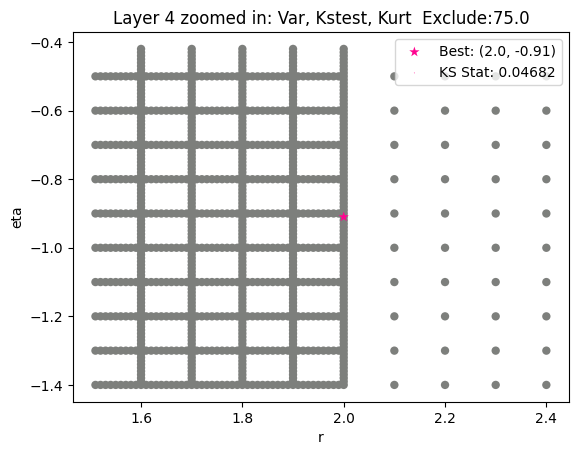

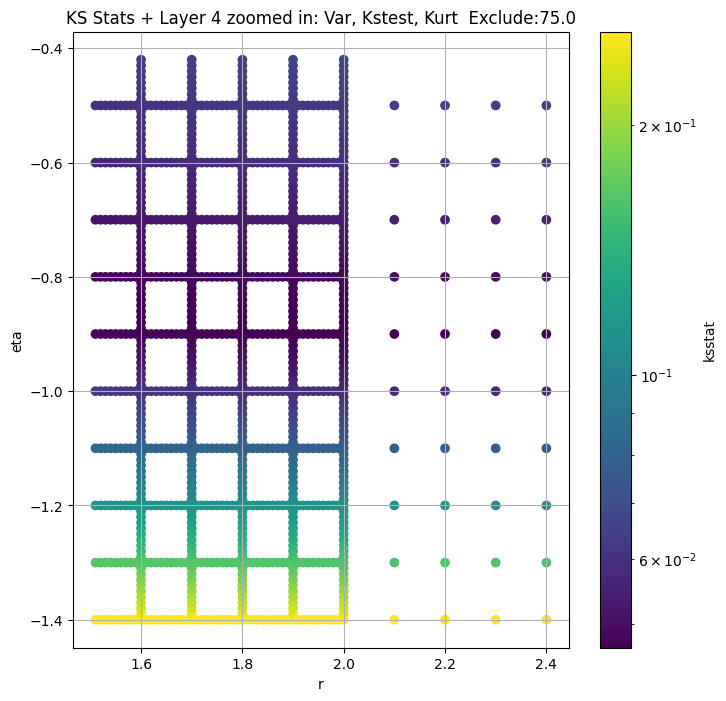

Layer 5


  0%|          | 0/1417 [00:00<?, ?it/s]

Finding Minimum after computing 1417 CDFs
layer 5, 500.0 + 100 = 600, ksstat: 0.03665906263636026, var: 47.2636833190918


  0%|          | 0/1417 [00:00<?, ?it/s]

Finding Minimum after computing 1417 CDFs
layer 5, 500.0 + 75 = 575, ksstat: 0.03665995140306022, var: 47.60491180419922


  0%|          | 0/1417 [00:00<?, ?it/s]

Finding Minimum after computing 1417 CDFs
layer 5, 500.0 + 50 = 550, ksstat: 0.03665838383660275, var: 47.952938079833984


  0%|          | 0/1417 [00:00<?, ?it/s]

Finding Minimum after computing 1417 CDFs
layer 5, 500.0 + 25 = 525, ksstat: 0.036658982976177035, var: 48.309200286865234


  0%|          | 0/1417 [00:00<?, ?it/s]

Finding Minimum after computing 1417 CDFs
layer 5, 500.0 + 0 = 500, ksstat: 0.03665937594401342, var: 48.673744201660156


  0%|          | 0/1417 [00:00<?, ?it/s]

Finding Minimum after computing 1417 CDFs
layer 5, 500.0 + -25 = 475, ksstat: 0.03665950688804703, var: 49.045127868652344


  0%|          | 0/1417 [00:00<?, ?it/s]

Finding Minimum after computing 1417 CDFs
layer 5, 500.0 + -50 = 450, ksstat: 0.03665941029838593, var: 49.42597961425781


  0%|          | 0/1417 [00:00<?, ?it/s]

Finding Minimum after computing 1417 CDFs
layer 5, 500.0 + -75 = 425, ksstat: 0.036659043294488824, var: 49.81561279296875


  0%|          | 0/1417 [00:00<?, ?it/s]

Finding Minimum after computing 1417 CDFs
layer 5, 500.0 + -100 = 400, ksstat: 0.03665842582377976, var: 50.216251373291016
Number of samples: 100000, Without approximation : 156544


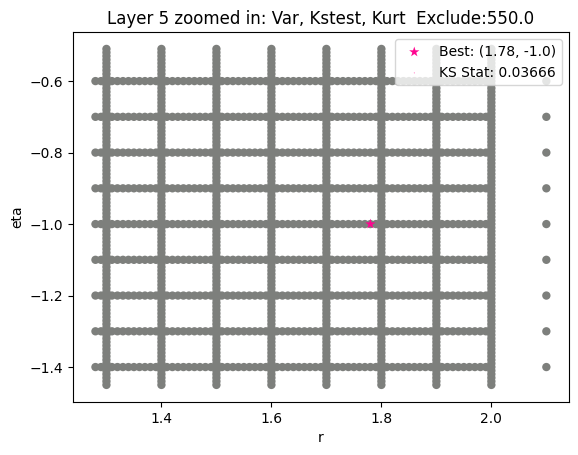

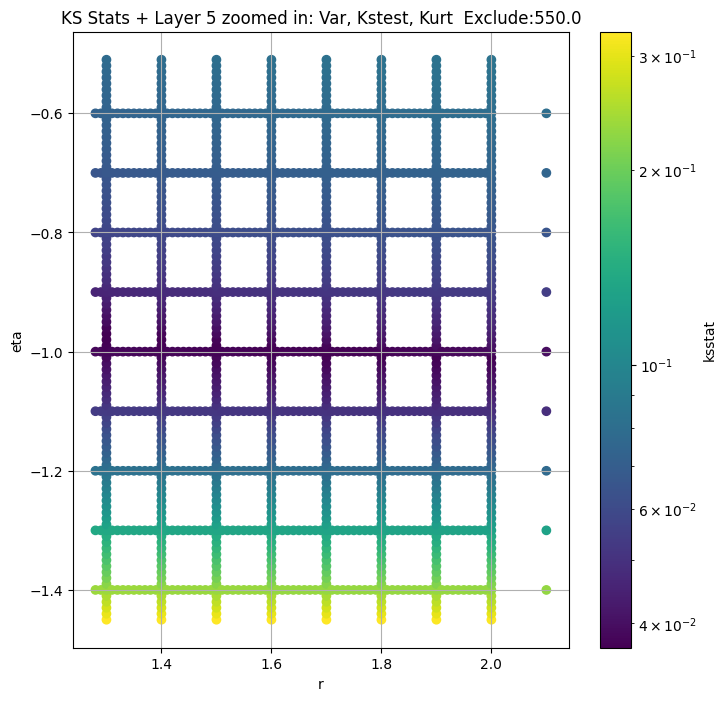

Layer 6


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 6, 250.0 + 100 = 350, ksstat: 0.028824119334288245, var: 9.477492332458496


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 6, 250.0 + 75 = 325, ksstat: 0.0288613000816193, var: 9.578542709350586


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 6, 250.0 + 50 = 300, ksstat: 0.02890208310218878, var: 9.683001518249512


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 6, 250.0 + 25 = 275, ksstat: 0.028943726246147272, var: 9.791357040405273


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 6, 250.0 + 0 = 250, ksstat: 0.028986477708085656, var: 9.90441608428955


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 6, 250.0 + -25 = 225, ksstat: 0.02903030260496653, var: 10.022271156311035


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 6, 250.0 + -50 = 200, ksstat: 0.02905639757548406, var: 10.145769119262695


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 6, 250.0 + -75 = 175, ksstat: 0.028935454423001772, var: 10.275765419006348


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 6, 250.0 + -100 = 150, ksstat: 0.028931226609448135, var: 10.412787437438965
Number of samples: 100000, Without approximation : 626176


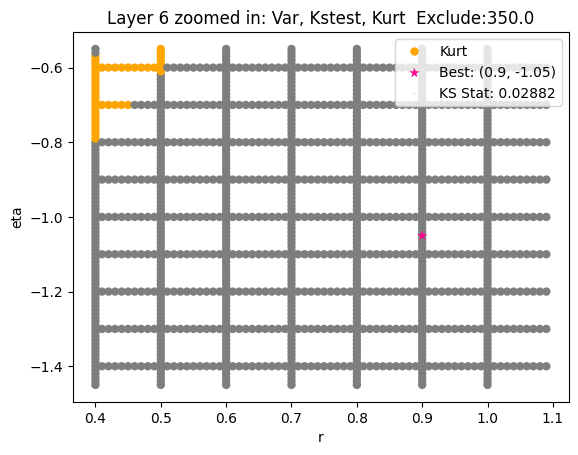

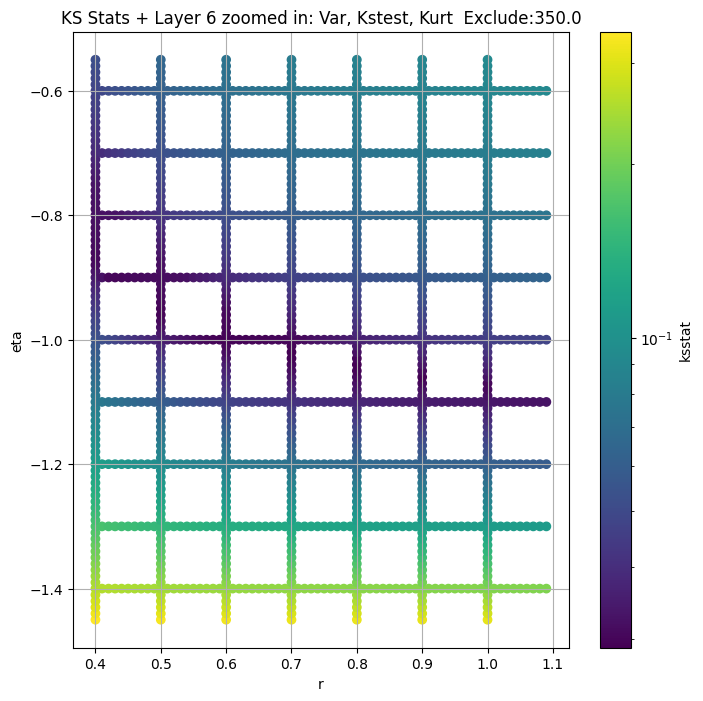

Layer 7


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 7, 500.0 + 100 = 600, ksstat: 0.025030956926765602, var: 1.6019926071166992


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 7, 500.0 + 75 = 575, ksstat: 0.025114727099118328, var: 1.618809461593628


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 7, 500.0 + 50 = 550, ksstat: 0.025199515790682858, var: 1.6360727548599243


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 7, 500.0 + 25 = 525, ksstat: 0.025264096828317095, var: 1.6537997722625732


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 7, 500.0 + 0 = 500, ksstat: 0.02496120199219032, var: 1.6720480918884277


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 7, 500.0 + -25 = 475, ksstat: 0.02492666829140361, var: 1.6908169984817505


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 7, 500.0 + -50 = 450, ksstat: 0.025018129538999456, var: 1.710139513015747


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 7, 500.0 + -75 = 425, ksstat: 0.02503145582447841, var: 1.7300573587417603


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 7, 500.0 + -100 = 400, ksstat: 0.024711940874141525, var: 1.7506147623062134
Number of samples: 100000, Without approximation : 2504704


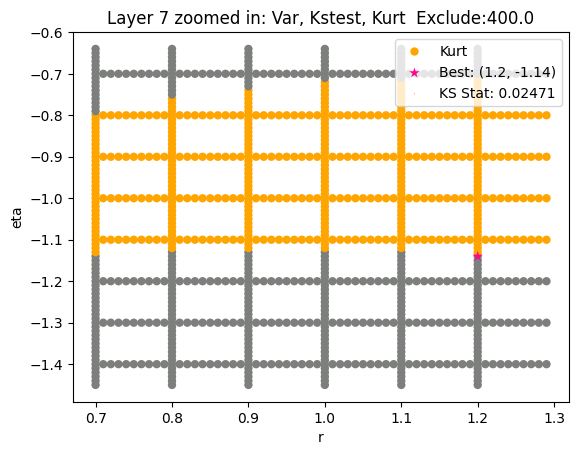

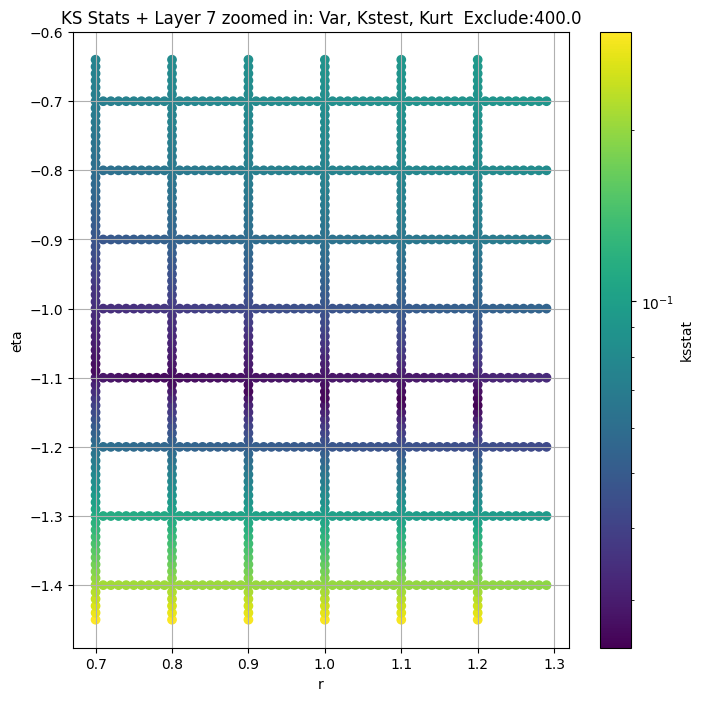

Layer 8


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
layer 8, 0.0 + 100 = 100, ksstat: 0.01325954913428773, var: 0.4558425545692444


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
layer 8, 0.0 + 75 = 75, ksstat: 0.01280973152737297, var: 0.46599218249320984


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
layer 8, 0.0 + 50 = 50, ksstat: 0.013156158641698279, var: 0.477461040019989


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
layer 8, 0.0 + 25 = 25, ksstat: 0.013107532257365273, var: 0.4911094605922699


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
layer 8, 0.0 + 0 = 0, ksstat: 0.013487870020038706, var: 0.5187497138977051
Number of samples: 100000, Without approximation : 10018816


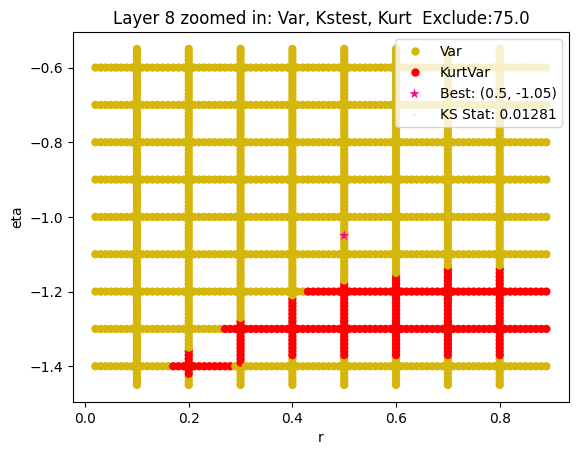

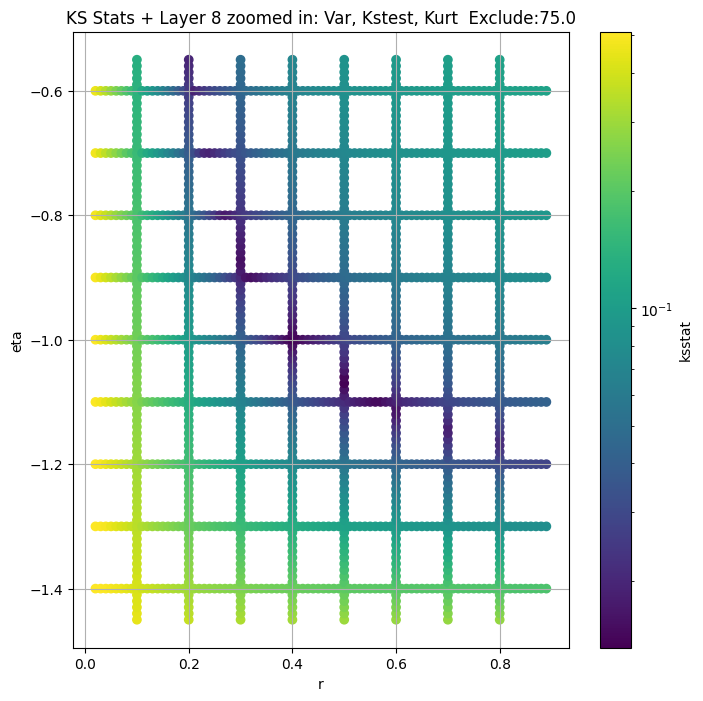

Layer 9


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
layer 9, 250.0 + 100 = 350, ksstat: 0.011465603061769136, var: 0.10292337089776993


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
layer 9, 250.0 + 75 = 325, ksstat: 0.011361437538672026, var: 0.10445136576890945


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
layer 9, 250.0 + 50 = 300, ksstat: 0.01125492227474112, var: 0.10604562610387802


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
layer 9, 250.0 + 25 = 275, ksstat: 0.011146908621541107, var: 0.10771337896585464


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
layer 9, 250.0 + 0 = 250, ksstat: 0.01137110035442046, var: 0.1094624325633049


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
layer 9, 250.0 + -25 = 225, ksstat: 0.011307310305828877, var: 0.11130289733409882


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
layer 9, 250.0 + -50 = 200, ksstat: 0.010390921501262085, var: 0.11324675381183624


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
layer 9, 250.0 + -75 = 175, ksstat: 0.010340222348618977, var: 0.11530858278274536


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
layer 9, 250.0 + -100 = 150, ksstat: 0.010004422986823358, var: 0.11750917136669159
Number of samples: 100000, Without approximation : 40075264


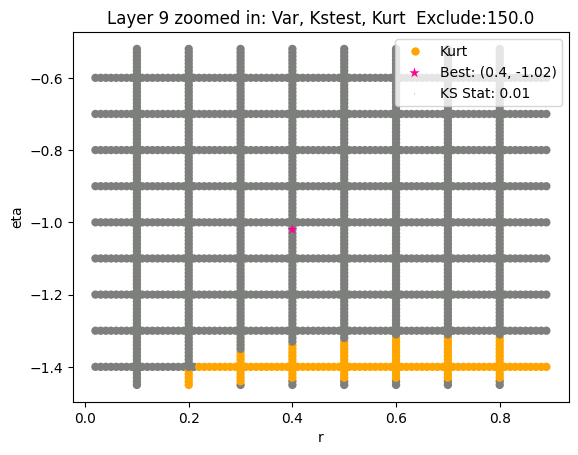

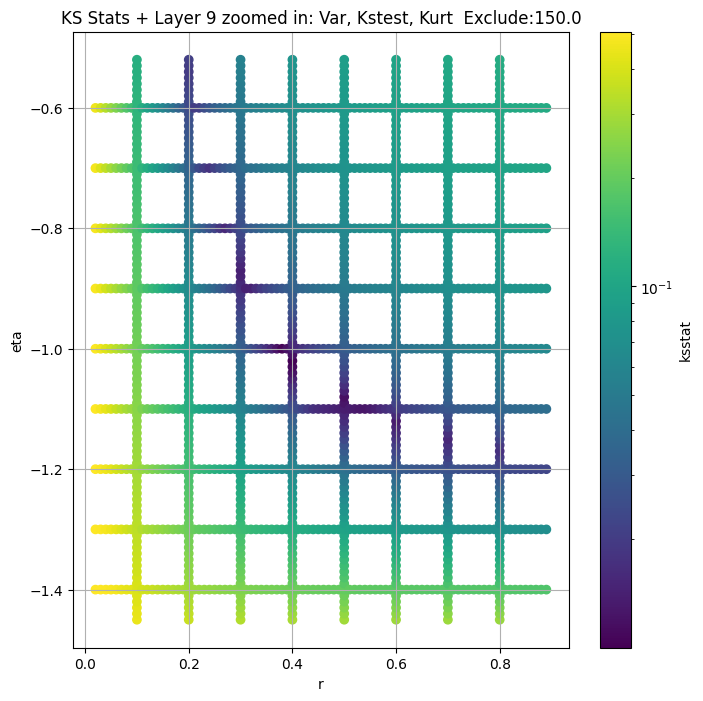

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      8164.916000  7605.077600  8740.630000  -0.209310   -0.378561   
3      1626.509200  1553.716800  1701.747200   1.064677    0.871749   
4       312.339840   295.463650   329.815400   2.542057    2.153969   
5        59.957355    55.956010    64.163605   5.134632    4.186793   
6        11.683060    10.743300    12.710672   8.652102    6.385494   
7         2.319137     2.099334     2.582869  13.925329    8.620293   
8         0.518750     0.462717     0.602915  23.163664   10.309817   
9         0.140365     0.124805     0.164263  25.354736   11.124588   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2       -0.024999           2446             0.084558        7.9          1.4   
3        1.268122           9784             0.068415        0.3          2.1   
4        2.983537          39136             0.046860        2.0         -0.9   
5        6.364203         156544             0.036684        1.7         -1.0   
6       15.483664         626176             0.029212        0.6         -1.0   
7       37.670284        2504704             0.025986        0.8         -1.1   
8       97.696720       10018816             0.013488        0.4         -1.0   
9      102.650770       40075264             0.011371        0.4         -1.0   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       11024.006477                     0.0         8164.916000   
3           0.286218                    25.0         1350.162598   
4         712.736023                   150.0          291.530762   
5         137.243191                   500.0           47.952938   
6           8.410168                   250.0            9.477492   
7           3.224621                   500.0            1.750615   
8           0.106307                     0.0            0.465992   
9           0.022432                   250.0            0.117509   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                     0.027391          0.084558    7.90      1.40   
3                     0.013713          0.068414    0.37      2.10   
4                     0.006861          0.046822    2.00     -0.91   
5                     0.003431          0.036658    1.78     -1.00   
6                     0.001716          0.028824    0.90     -1.05   
7                     0.000858          0.024712    1.20     -1.14   
8                     0.000429          0.012810    0.50     -1.05   
9                     0.000215          0.010004    0.40     -1.02   

         best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                  
2      11024.006477                  0.0          256  
3          2.312859                100.0          384  
4        758.768893                 75.0          868  
5        137.324708                550.0         1375  
6         18.773065                350.0         2319  
7          5.578822                400.0         3094  
8          0.272510                 75.0        11007  
9          0.025870                150.0        18573

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

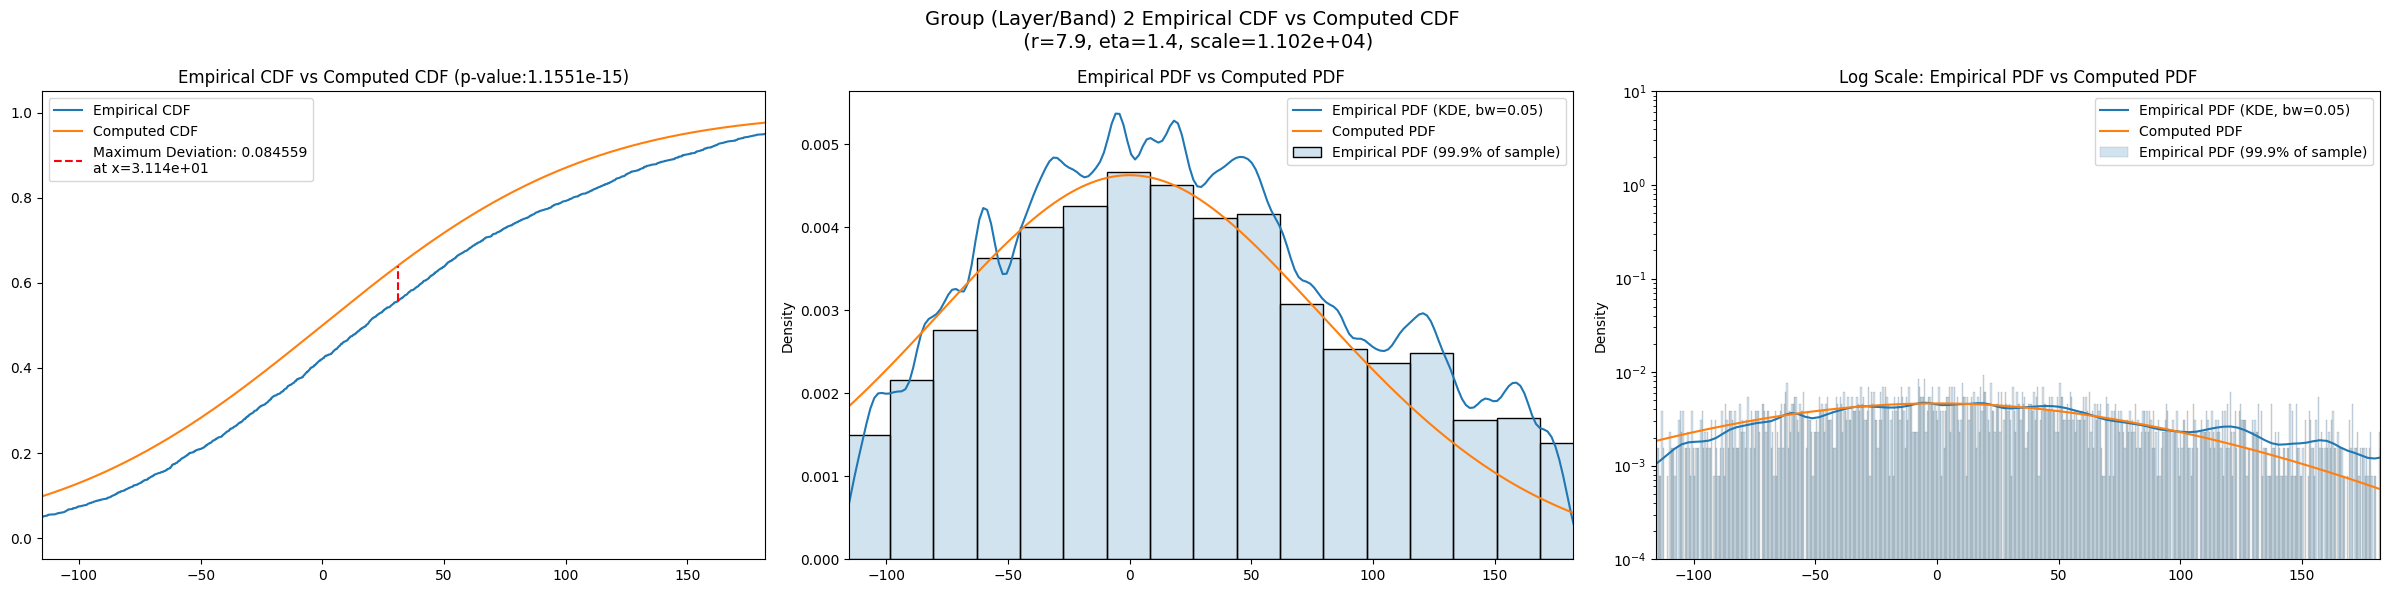

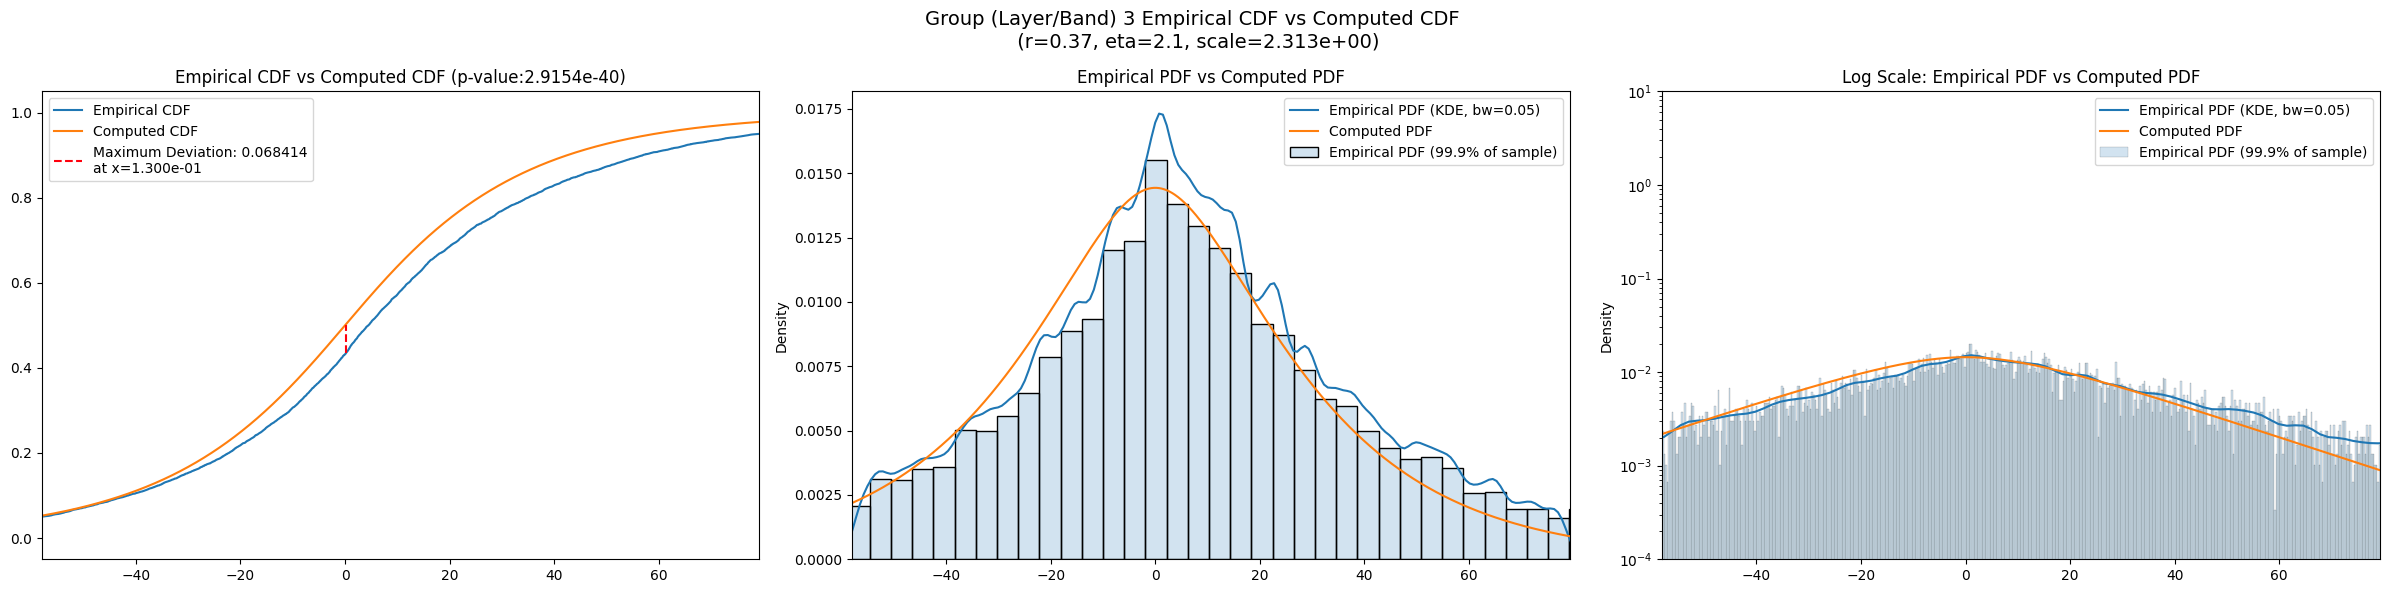

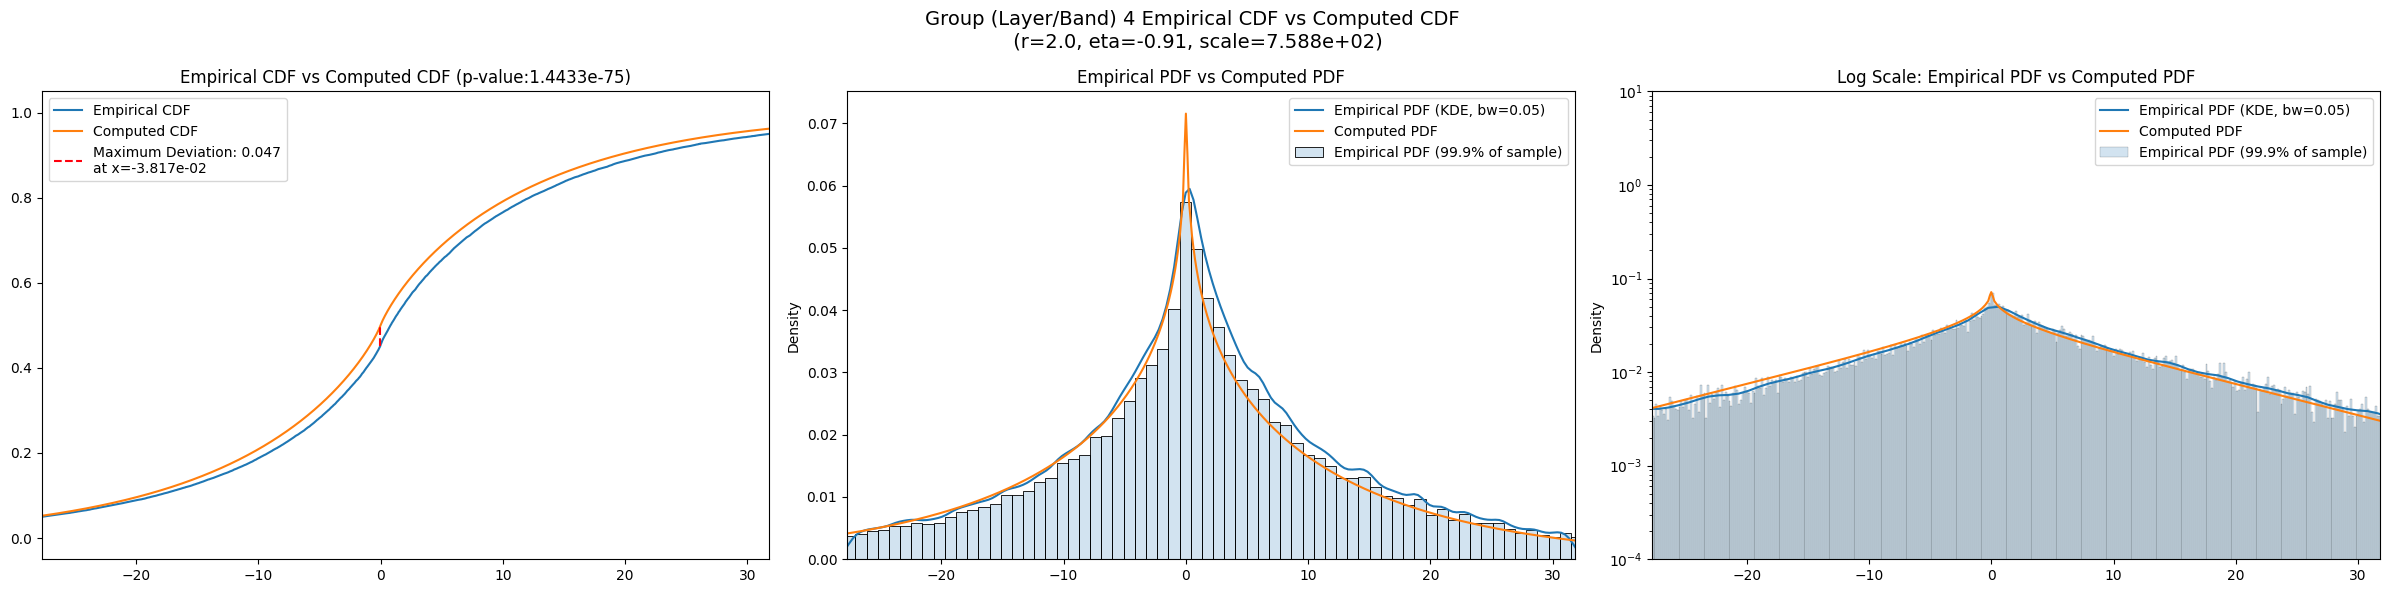

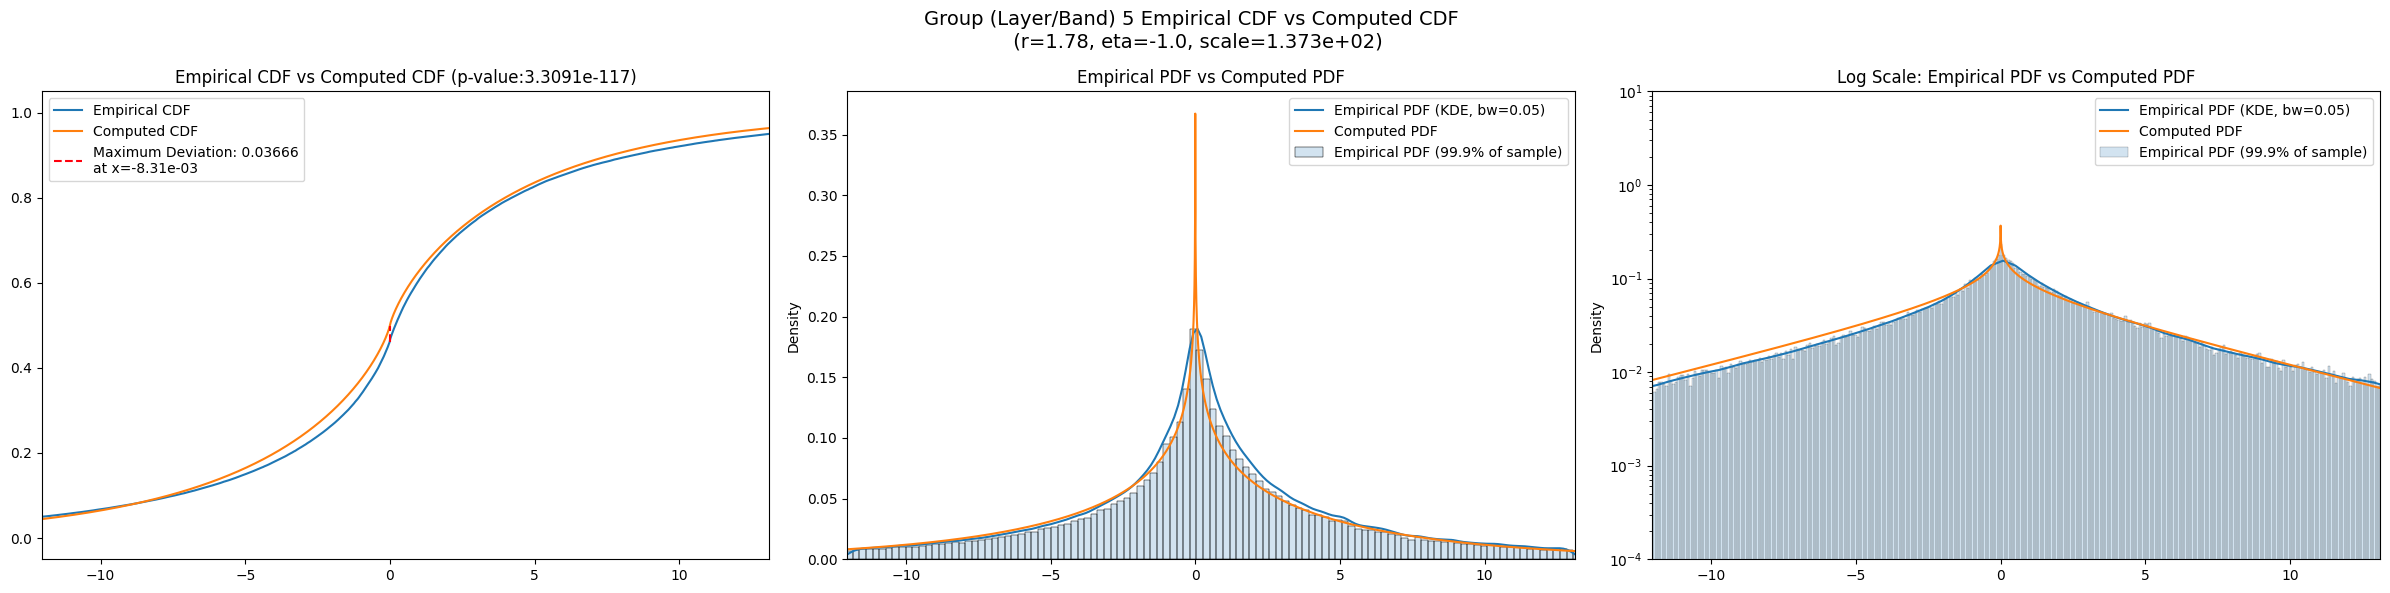

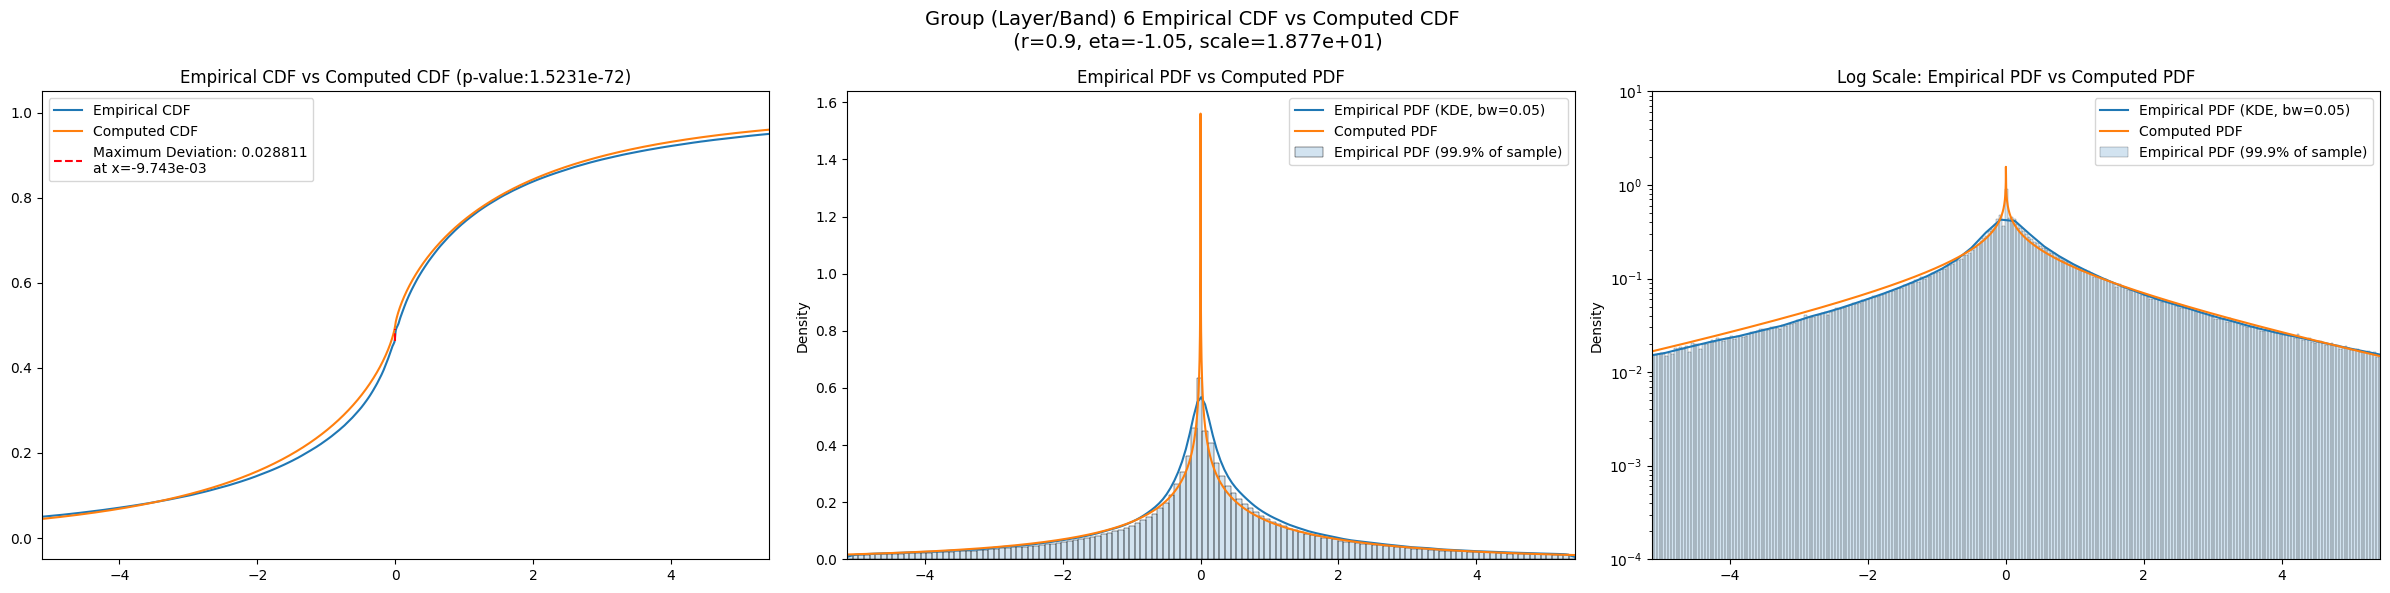

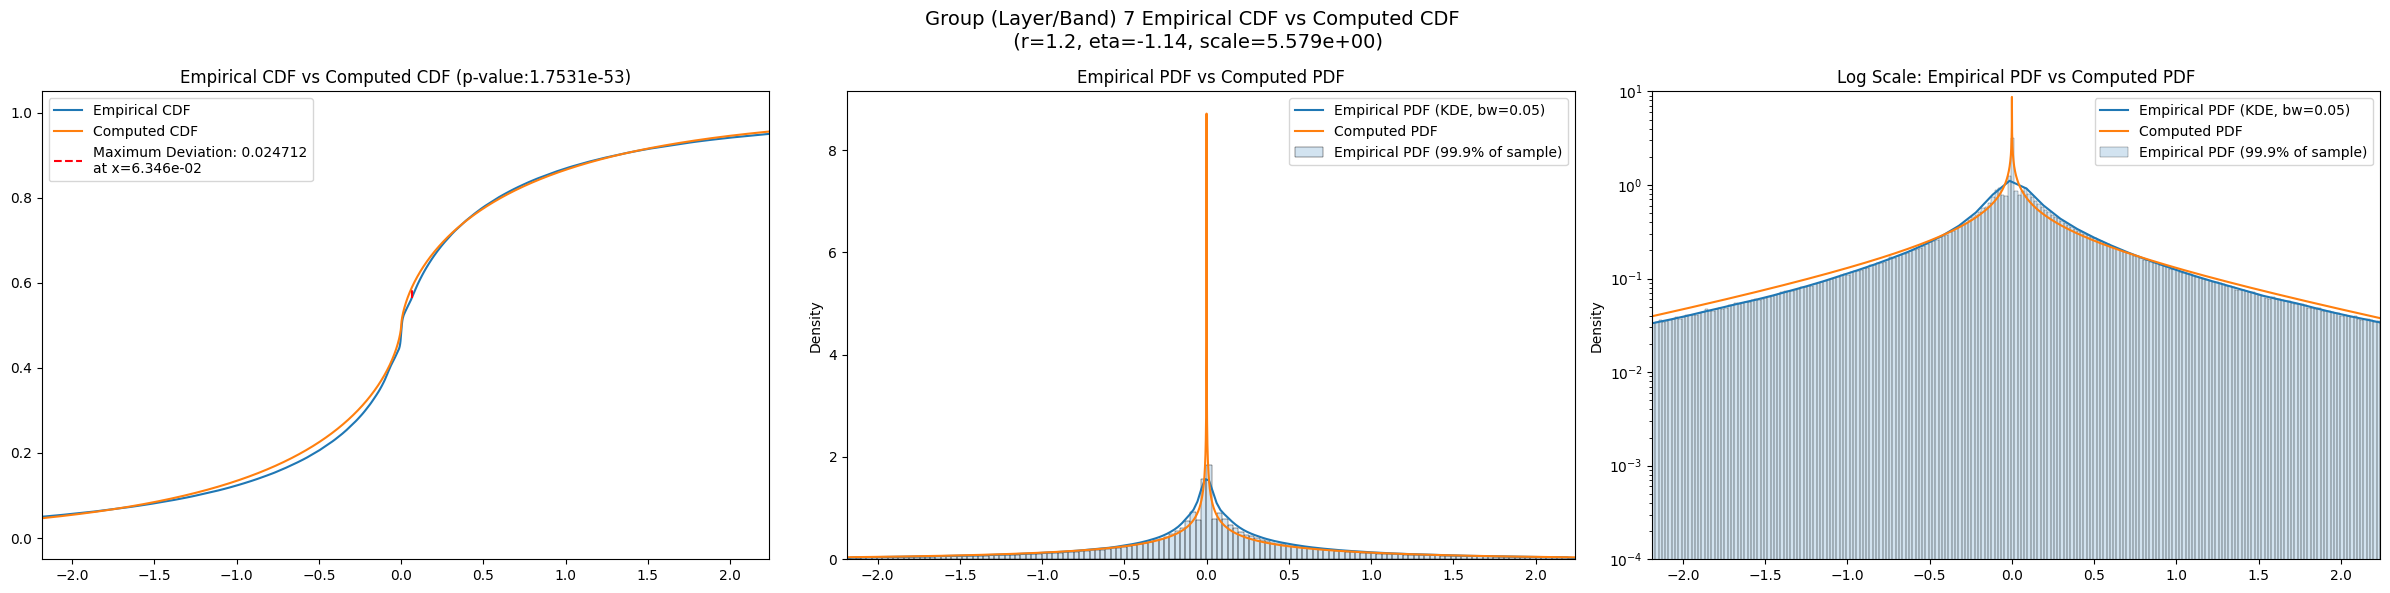

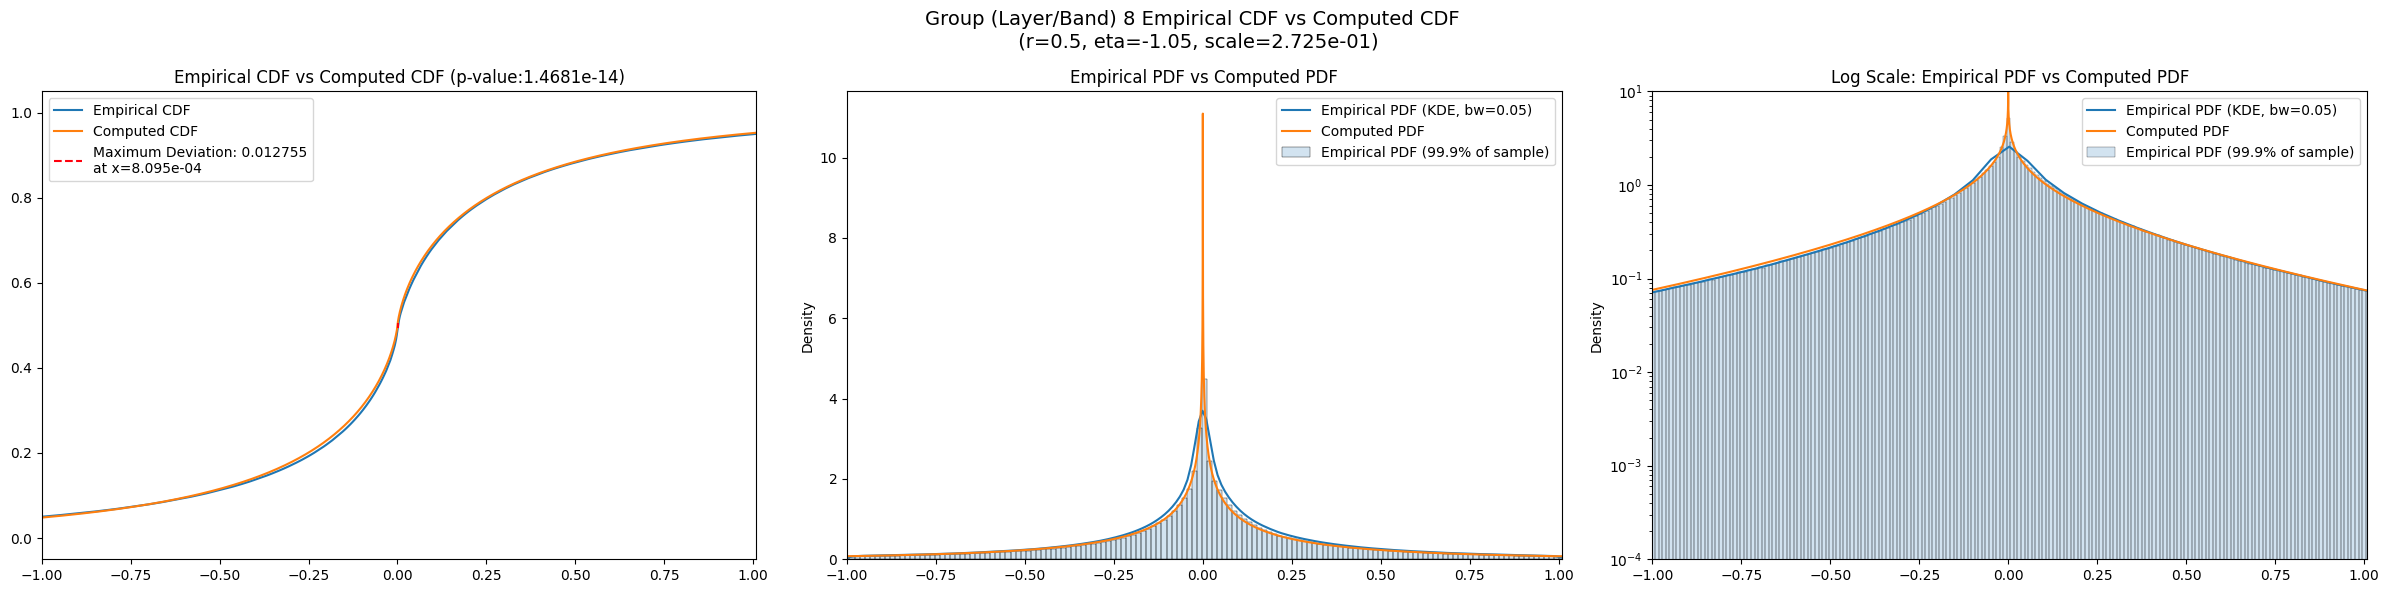

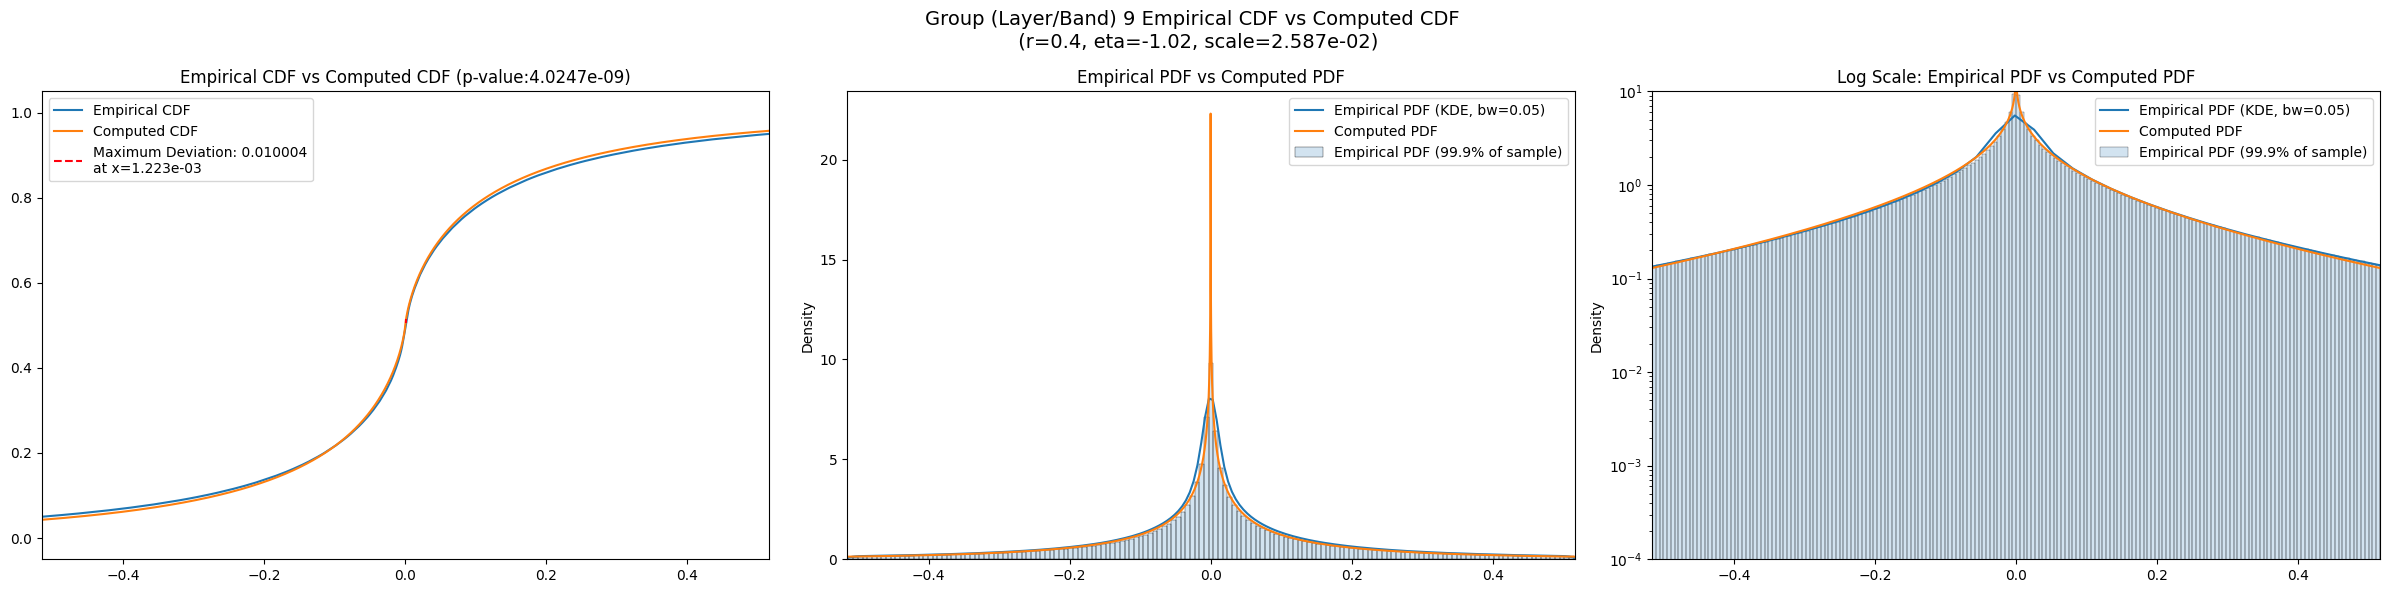

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      8164.916000  7605.077600  8740.630000  -0.209310   -0.378561   
3      1626.509200  1553.716800  1701.747200   1.064677    0.871749   
4       312.339840   295.463650   329.815400   2.542057    2.153969   
5        59.957355    55.956010    64.163605   5.134632    4.186793   
6        11.683060    10.743300    12.710672   8.652102    6.385494   
7         2.319137     2.099334     2.582869  13.925329    8.620293   
8         0.518750     0.462717     0.602915  23.163664   10.309817   
9         0.140365     0.124805     0.164263  25.354736   11.124588   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2       -0.024999           2446             0.084558        7.9          1.4   
3        1.268122           9784             0.068415        0.3          2.1   
4        2.983537          39136             0.046860        2.0         -0.9   
5        6.364203         156544             0.036684        1.7         -1.0   
6       15.483664         626176             0.029212        0.6         -1.0   
7       37.670284        2504704             0.025986        0.8         -1.1   
8       97.696720       10018816             0.013488        0.4         -1.0   
9      102.650770       40075264             0.011371        0.4         -1.0   

       ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer  ...                                                               
2      ...       86.819100              0.084818          9.313630e-16   
3      ...       31.533800              0.072662          2.289050e-45   
4      ...       12.077200              0.065797         9.471690e-148   
5      ...        4.393450              0.073047          0.000000e+00   
6      ...        1.647400              0.077183          0.000000e+00   
7      ...        0.670885              0.074843          0.000000e+00   
8      ...        0.300431              0.074671          0.000000e+00   
9      ...        0.144028              0.078712          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
layer                                                                       
2          89.413000             0.092559         1.095050e-18  74.633900   
3          33.928100             0.068450         2.649460e-40  24.496400   
4          10.195000             0.049870         5.010540e-85   8.634430   
5           3.733330             0.048694         0.000000e+00   3.038140   
6           1.409440             0.051597         0.000000e+00   1.125990   
7           0.574173             0.049463         0.000000e+00   0.454956   
8           0.256560             0.049545         0.000000e+00   0.201800   
9           0.122809             0.054001         0.000000e+00   0.095990   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.085486   5.322780e-16          1.155873e-15  
3           0.068414   2.917490e-40          2.915416e-40  
4           0.053857   4.184580e-99          5.363802e-75  
5           0.053404   0.000000e+00         3.245794e-183  
6           0.055225   0.000000e+00          0.000000e+00  
7           0.052089   0.000000e+00          0.000000e+00  
8           0.052168   0.000000e+00          0.000000e+00  
9           0.055936   0.000000e+00          0.000000e+00  

[8 rows x 30 columns]

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                 0.084558                 0.027391          0.084558   
3                 0.068415                 0.013713          0.068414   
4                 0.046860                 0.006861          0.046822   
5                 0.036684                 0.003431          0.036658   
6                 0.029212                 0.001716          0.028824   
7                 0.025986                 0.000858          0.024712   
8                 0.013488                 0.000429          0.012810   
9                 0.011371                 0.000215          0.010004   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                  0.084818             0.092559       0.085486  
3                  0.072662             0.068450       0.068414  
4                  0.065797             0.049870       0.053857  
5                  0.073047             0.048694       0.053404  
6                  0.077183             0.051597       0.055225  
7                  0.074843             0.049463       0.052089  
8                  0.074671             0.049545       0.052168  
9                  0.078712             0.054001       0.055936

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
layer                                                                         
2             8164.916000          0.084558    7.90      1.40  11024.006477   
3             1350.162598          0.068414    0.37      2.10      2.312859   
4              291.530762          0.046822    2.00     -0.91    758.768893   
5               47.952938          0.036658    1.78     -1.00    137.324708   
6                9.477492          0.028824    0.90     -1.05     18.773065   
7                1.750615          0.024712    1.20     -1.14      5.578822   
8                0.465992          0.012810    0.50     -1.05      0.272510   
9                0.117509          0.010004    0.40     -1.02      0.025870   

       best_exclude_cutoff  
layer                       
2                      0.0  
3                    100.0  
4                     75.0  
5                    550.0  
6                    350.0  
7                    400.0  
8                     75.0  
9                    150.0

In [21]:
eng.quit()